In [266]:
%matplotlib inline
import pandas as pd  # Data manipulation
import ciw  # The discrete event simulation library we will use to study queues
import matplotlib.pyplot as plt  # Plots
import seaborn as sns  # Powerful plots
from scipy import stats  # Linear regression
import numpy as np  # Quick summary statistics
import tqdm  # A progress bar

# Anscombe's quartet and queueing theory with the Ciw Python library.

[Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) is a great example of the importance of fully understanding variability in a data set: it is a set of 4 data sets with the same summary measures (mean, std, etc...), the same correlation and the same regression line **but** with very different distribution. In this post I'll show how easy it is to play with Anscombe's quartet using Python and then talk about another mathematical area where variability must be fully understood: the study of queues. I'll do this with the [Ciw](http://ciw.readthedocs.org/) python library.

## Anscombe's quartet

First of all, let us get the data set, that's immediate to do as it comes ready loadable within the seaborn package:

In [2]:
anscombe = sns.load_dataset("anscombe")

We can see that there are 4 data set each with different values of $x$ and $y$:

In [336]:
print(anscombe)

   dataset     x      y
0        I  10.0   8.04
1        I   8.0   6.95
2        I  13.0   7.58
3        I   9.0   8.81
4        I  11.0   8.33
5        I  14.0   9.96
6        I   6.0   7.24
7        I   4.0   4.26
8        I  12.0  10.84
9        I   7.0   4.82
10       I   5.0   5.68
11      II  10.0   9.14
12      II   8.0   8.14
13      II  13.0   8.74
14      II   9.0   8.77
15      II  11.0   9.26
16      II  14.0   8.10
17      II   6.0   6.13
18      II   4.0   3.10
19      II  12.0   9.13
20      II   7.0   7.26
21      II   5.0   4.74
22     III  10.0   7.46
23     III   8.0   6.77
24     III  13.0  12.74
25     III   9.0   7.11
26     III  11.0   7.81
27     III  14.0   8.84
28     III   6.0   6.08
29     III   4.0   5.39
30     III  12.0   8.15
31     III   7.0   6.42
32     III   5.0   5.73
33      IV   8.0   6.58
34      IV   8.0   5.76
35      IV   8.0   7.71
36      IV   8.0   8.84
37      IV   8.0   8.47
38      IV   8.0   7.04
39      IV   8.0   5.25
40      IV  19.0

Let us take a quick look at the summary measures:

In [337]:
print(anscombe.groupby("dataset").describe())

                       x          y
dataset                            
I       count  11.000000  11.000000
        mean    9.000000   7.500909
        std     3.316625   2.031568
        min     4.000000   4.260000
        25%     6.500000   6.315000
        50%     9.000000   7.580000
        75%    11.500000   8.570000
        max    14.000000  10.840000
II      count  11.000000  11.000000
        mean    9.000000   7.500909
        std     3.316625   2.031657
        min     4.000000   3.100000
        25%     6.500000   6.695000
        50%     9.000000   8.140000
        75%    11.500000   8.950000
        max    14.000000   9.260000
III     count  11.000000  11.000000
        mean    9.000000   7.500000
        std     3.316625   2.030424
        min     4.000000   5.390000
        25%     6.500000   6.250000
        50%     9.000000   7.110000
        75%    11.500000   7.980000
        max    14.000000  12.740000
IV      count  11.000000  11.000000
        mean    9.000000   7

We see that the summary statistics are, if not the same (a mean in $x$ of 9, in $y$ of 7.5) **very similar**. We can also take a look at the relationship between $x$ and $y$ in each data set by computing the regression line and visualising it:

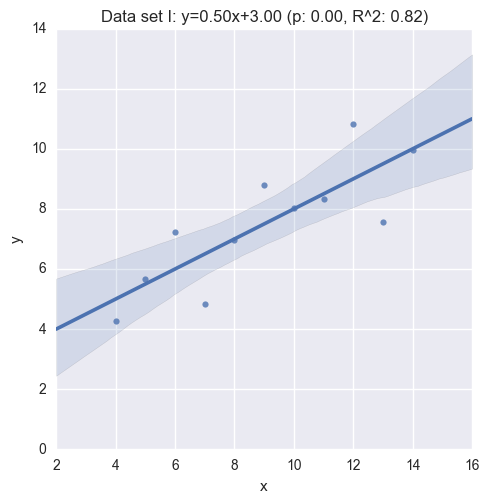

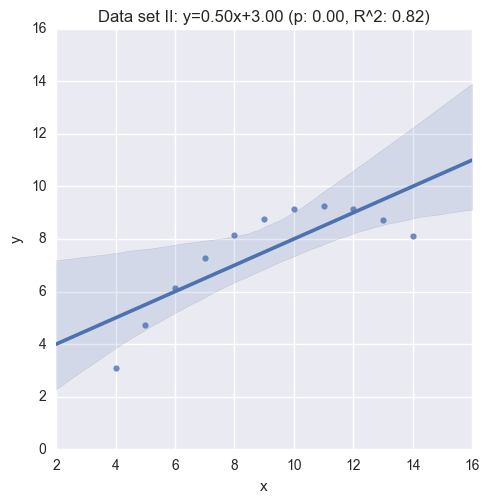

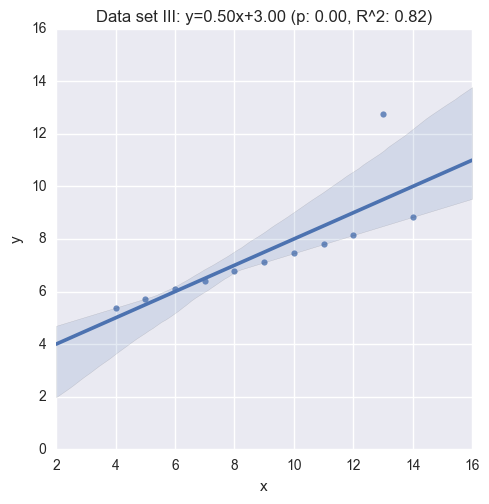

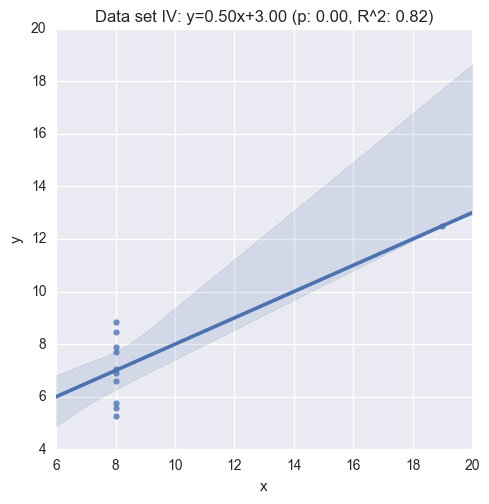

In [322]:
for data_set in anscombe.dataset.unique():
    df = anscombe.query("dataset == '{}'".format(data_set))
    slope, intercept, r_val, p_val, slope_std_error = stats.linregress(x=df.x, y=df.y)
    sns.lmplot(x="x", y="y", data=df);
    plt.title("Data set {}: y={:.2f}x+{:.2f} (p: {:.2f}, R^2: {:.2f})".format(data_set, slope, intercept, p_val, r_val))
    plt.savefig("anscombe-{}.png".format(data_set), dpi=400);

While the plots show that each data set is evidently different, they also all have the same regression line (with the same $p, R^2$ values!):

$$y=0.50x+3$$

Anscombe's quartet is often used as an example justifying that a summary of a data set will inherently lose information and so should be accompanied by further study/understanding (such as in this case: viewing the plots of the data). (There even a paper out there showing how to generate similar data sets (behind a paywall): ["Generating Data with Identical Statistics but Dissimilar Graphics: A Follow up to the Anscombe Dataset"](https://www.jstor.org/stable/27643902))

## Variability in queues

Another area of mathematics where it is imperative to have a good understanding of variability is [queueing theory](https://en.wikipedia.org/wiki/Queueing_theory) which is (suprise suprise) the study of queues. I've written about queueing theory before: here is a post [about calculating the expected wait in a tandem queue](http://vknight.org/unpeudemath/code/2014/09/19/the-expected-waiting-time-in-a-tandem-queue-with-blocking-using-sage.html), the main idea however is to assume some (random) distribution for the time between arrivals of individuals at a queueing system and another (random) distribution for the time it takes to "service" each individual.

When studied analytically these are often studied as [Markov chains](https://en.wikipedia.org/wiki/Markov_chain). The wikipedia entry for a single server queue https://en.wikipedia.org/wiki/Queueing_theory#Example_of_M.2FM.2F1 shows a picture for the corresponding chain.

These Markov models of queues assume that the distributions (of inter arrival times and service times) are Markovian: ie correspond to exponential distributions. This is often a good distribution that models realistic situations, **however** it is just as often not realistic. For example in healthcare systems such as hospital wards (which are just queues) service time distributions often follow a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution).

When studying queues, as well as building analytical models it is possible to simulate the process using pseudo random number generators. One piece of software (the main developer being [Paul Harper](http://www.profpaulharper.com/) and my PhD student: [Geraint Palmer](http://www.geraintianpalmer.org.uk/)) that allows for this is [ciw](http://ciw.readthedocs.io/en/latest/) (the name is Welsh for queue! :)).

What I'll do in the rest of this post is build a simulation model of a single server queue with ciw where individuals:

- Arrive on **average** according to a rate of 0.5 per time unit (so 2 time units between arrivals);
- Are served on **average** at a rate of 1 per time unit (so 1 time units per service).

To do this in ciw we need to set up a parameters dictionary. Ciw is written so as to handle most queueing systems but with queueing networks in mind in particular and also the ability to handle multiple classes of individuals. In our system we will just have one class of individuals `Class 0` and the transition matrix is a bit redundant because we're dealing with a single queue. Here is the dictionary for our system when assuming exponential distributions:

In [323]:
parameters = {'Arrival_distributions': {'Class 0': [['Exponential', 0.5]]},   
              'Service_distributions': {'Class 0': [['Exponential', 1]]},
              'Transition_matrices': {'Class 0': [[0.0]]},  
              'Number_of_servers': [1]}

In [324]:
def iteration(parameters, maxtime=250, warmup=50):
    """
    Run a single iteration of the simulation and 
    return the times spent waiting for service 
    as well as the service times
    """
    N = ciw.create_network(parameters)  
    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(maxtime)
    records = [r for r in  Q.get_all_records() if r.arrival_date > warmup]
    waits = [r.waiting_time for r in records]
    service_times = [r.service_time for r in records]
    n = len(waits)
    return waits, service_times

In [325]:
def trials(parameters, repetitions=30, maxtime=2000, warmup=250):
    """Repeat out simulation over a number of trials"""
    waits = []
    service_times = []
    for seed in tqdm.trange(repetitions):  # tqdm gives us a nice progress bar
        ciw.seed(seed)
        wait, service_time = iteration(parameters, maxtime=maxtime, warmup=warmup)
        waits.extend(wait)
        service_times.extend(service_time)
    return waits, service_times

In [326]:
waits, service_times = trials(parameters)

First, let us verify that we are getting the expected service time (recall it should be 1 time units):

In [327]:
np.mean(service_times)

1.0024931747410142

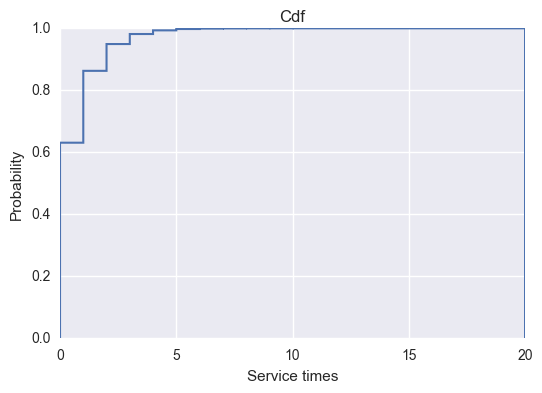

In [331]:
plt.hist(service_times, normed=True, cumulative=True, histtype = 'step', linewidth=1.5, bins=20, range=[0, 20])
plt.xlabel("Service times")
plt.ylabel("Probability")
plt.title("Cdf");

We can also check that mean wait agrees with the theoretical value of $\frac{\rho}{\mu(1-\rho)}$ where $\rho=\lambda/\mu$, with $\lambda$, $\mu$ being the interarrival and service rates.

In [312]:
lmbda = parameters['Arrival_distributions']['Class 0'][0][1]
mu = parameters['Service_distributions']['Class 0'][0][1]
rho = lmbda / mu
np.mean(waits), rho / (mu * (1 - rho))

(1.0299693832838621, 1.0)

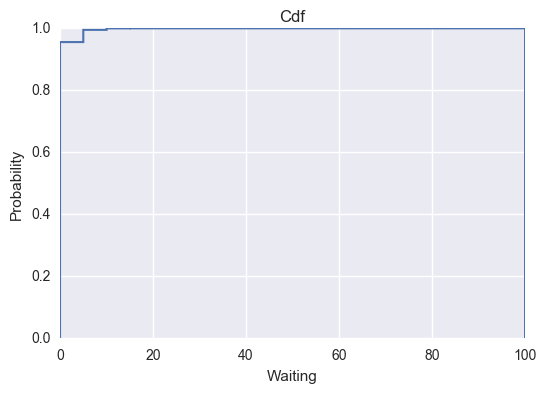

In [332]:
plt.hist(waits, normed=True, cumulative=True, histtype = 'step', linewidth=1.5, range=[0, 100], bins=20)
plt.xlabel("Waiting time")
plt.ylabel("Probability")
plt.title("Cdf");

Now that we have done this for a simple Markovian system let us create a number of distributions that all have the same mean service time and compare this:

In [236]:
distributions = [
    ['Uniform', 0, 2],  # A uniform distribution with mean 1
    ['Deterministic', 1],  # A deterministic distribution with mean 1
    ['Triangular', 0, 2, 1],  # A triangular distribution with mean 1
    ['Exponential', 1],  # The Markovian distribution with mean 1
    ['Gamma', 0.91, 1.1], # A Gamma distribution with mean 1
    ['Lognormal', 0, .1], # A lognormal distribution with mean 1
    ['Weibull', 1.1, 3.9],  # A Weibull distribuion with mean 1
    ['Empirical', [0] * 19 + [20]]  # An empirical distribution with mean 1 (95% of the time: 0, 5% of the time: 20)
]

(More info can be found at the ciw documentation on distributions: http://ciw.readthedocs.io/en/latest/Features/distributions.html.)

Let us know simulate the queueing process for all the above distribution:

In [314]:
columns = ["distribution", "waits", "service_times"]
df = pd.DataFrame(columns=columns)  # Create a dataframe that will keep all the data

data = {}
for distribution in distributions:
    parameters['Service_distributions']['Class 0'] = [distribution]
    waits, service_times = trials(parameters)
    n = len(waits)
    df = df.append(pd.DataFrame(list(zip([distribution[0]] * n, waits, service_times)), columns=columns))

If we look at the summary statistics we see that all distributions have the same mean service time **but** drastically different mean waiting times:

In [315]:
bydistribution = df.groupby("distribution")  # Grouping the data
for name, df in sorted(bydistribution, key= lambda dist: dist[1].waits.max()):
    print("{}:\n\t Mean service time: {:.02f}\n\t Mean waiting time: {:.02f}\n\t 95% waiting time: {:.02f} \n\t Max waiting time: {:.02f}\n".format(
                                                                              name, 
                                                                              df.service_times.mean(),
                                                                              df.waits.mean(), 
                                                                              df.waits.quantile(0.95), 
                                                                              df.waits.max()))

Deterministic:
	 Mean service time: 1.00
	 Mean waiting time: 0.51
	 95% waiting time: 2.11 
	 Max waiting time: 6.73

Weibull:
	 Mean service time: 1.00
	 Mean waiting time: 0.54
	 95% waiting time: 2.24 
	 Max waiting time: 8.16

Lognormal:
	 Mean service time: 1.01
	 Mean waiting time: 0.51
	 95% waiting time: 2.09 
	 Max waiting time: 8.53

Triangular:
	 Mean service time: 1.00
	 Mean waiting time: 0.59
	 95% waiting time: 2.48 
	 Max waiting time: 9.21

Uniform:
	 Mean service time: 1.00
	 Mean waiting time: 0.67
	 95% waiting time: 2.84 
	 Max waiting time: 10.42

Exponential:
	 Mean service time: 1.00
	 Mean waiting time: 1.03
	 95% waiting time: 4.76 
	 Max waiting time: 16.41

Gamma:
	 Mean service time: 1.00
	 Mean waiting time: 1.02
	 95% waiting time: 4.72 
	 Max waiting time: 20.65

Empirical:
	 Mean service time: 0.99
	 Mean waiting time: 9.30
	 95% waiting time: 37.60 
	 Max waiting time: 100.60



**But** just as we mentioned when looking at Anscombe's quartet it's important to not just look at summary statistics so here is some visualisation:

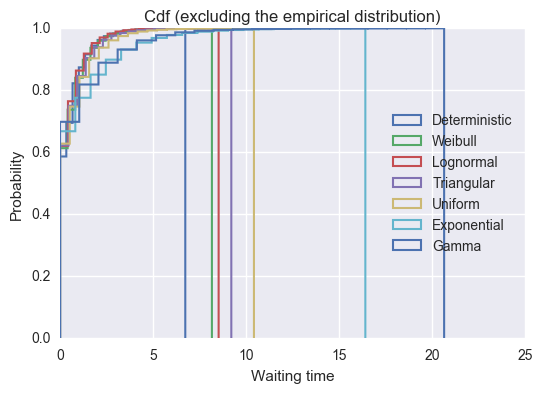

In [335]:
for name, df in sorted(bydistribution, key= lambda dist: dist[1].waits.max())[:-1]:
    plt.hist(df.waits, normed=True, bins=20, cumulative=True, 
             histtype = 'step', label=name, linewidth=1.5)
plt.title("Cdf (excluding the empirical distribution)")
plt.xlabel("Waiting time")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.legend(loc=5);

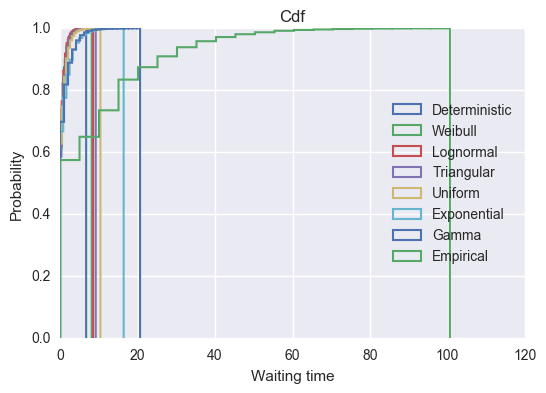

In [334]:
for name, df in sorted(bydistribution, key= lambda dist: dist[1].waits.max()):
    plt.hist(df.waits, normed=True, bins=20, cumulative=True, 
             histtype = 'step', label=name, linewidth=1.5)
plt.title("Cdf")
plt.xlabel("Waiting time")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.legend(loc=5);

We see that the empirical distribution has by far the longest tail with some individuals have more than 80 time units spent waiting. Whilst this distribution is pretty artificial. It is fairly realistic to assume that there is a particular procedure or service that often takes no time at all **but** rarely does take a lot of more time. Examples of these will include healthcare operations where non routine procedures sometimes are needed. 

This is all done with a pretty simple queueing system (just one server) but the [Ciw python library]() makes it pretty easy to study more complex systems.